In [8]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tqdm import tqdm
import numpy as np
from torchtext.data.utils import get_tokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from imblearn.over_sampling import RandomOverSampler
# 加载数据
file_path = "./douyin.csv"  # 请确保路径正确
data = pd.read_csv(file_path)
def remove_non_alphabet(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)
# 数据准备
data = data.dropna(subset=['222'])
X = data['222'].astype(str).apply(remove_non_alphabet)
y = data['333'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

# 检查数据集分布
print("数据集分布:")
print(y.value_counts())


def remove_words(text, words_to_remove):
    # 构建正则表达式模式
    pattern = r'\b(?:' + '|'.join(re.escape(word) for word in words_to_remove) + r')\b'
    # 删除指定单词
    return re.sub(pattern, '', text)
words_to_remove = ["e", "D","app","video","the","��|?��|?��|?","��??��","��???","��?��?","and","o","O","???","?????","Tiktok","to","tiktok","tik","tok","videos","oe","1e","ae","2e","3e","is","TikTok","Tik","Tok","a"]
X = X.apply(lambda x: remove_words(x, words_to_remove))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)
X_train_res = X_train_res.flatten()


# 检查训练集和测试集数据分布
print("训练集数据分布:")
print(y_train.value_counts())

print("测试集数据分布:")
print(y_test.value_counts())

print("过采样后的训练集数据分布:")
print(pd.Series(y_train_res).value_counts())
# 标签编码
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train_res)
y_test_enc = label_encoder.transform(y_test)
y_all_enc = label_encoder.fit_transform(y)  # 使用完整的数据进行编码

# 数据集类
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text)
        # 检查 tokens 是否为字符串，如果是，则转换为整数索引
        if isinstance(tokens, list) and all(isinstance(token, str) for token in tokens):
            tokens = [vocab[token] if token in vocab else 0 for token in tokens]  # 使用词汇表将字符串转换为整数
        tokens = tokens[:self.max_len]
        tokens += [0] * (self.max_len - len(tokens))
        # 检查 tokens 是否为整数序列
        assert all(isinstance(token, int) for token in tokens), "tokens 包含非整数值"
        return torch.tensor(tokens), torch.tensor(label)

# Tokenizer和Padding
tokenizer = get_tokenizer('basic_english')
max_len = 100

# 构建词汇表
vocab = {}
for text in X_train_res:
    for token in tokenizer(text):
        if token not in vocab:
            vocab[token] = len(vocab) + 1  # 词汇表索引从1开始，0用于填充

# 检查 Tokenizer 是否正常工作
example_text = X_train_res[0]
example_tokens = tokenizer(example_text)
example_indices = [vocab[token] if token in vocab else 0 for token in example_tokens]  # 将字符串转换为整数索引
print(f"Example text: {example_text}")
print(f"Tokenized: {example_tokens}")
print(f"Token indices: {example_indices}")

# 构建数据集和数据加载器
train_dataset = TextDataset(X_train_res.tolist(), y_train_enc, tokenizer, max_len)
test_dataset = TextDataset(X_test.tolist(), y_test_enc, tokenizer, max_len)
all_dataset = TextDataset(X.tolist(), y_all_enc, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4096)
all_loader = DataLoader(all_dataset, batch_size=8192)  # 调整批次大小以适应所有数据

# 模型定义
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.conv = nn.Conv1d(embed_size, 128, 5)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(128 * (max_len // 2 - 2), 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.pool(torch.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, h_n = self.rnn(x)
        x = torch.relu(self.fc1(h_n[-1]))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        x = torch.relu(self.fc1(h_n[-1]))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# 训练函数
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for texts, labels in tqdm(train_loader, desc="训练进度"):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 评估函数
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 参数设置
vocab_size = len(vocab) + 1  # 词汇表大小加1，因为索引从1开始
embed_size = 128
hidden_size = 128
num_classes = 3

# 创建模型、损失函数和优化器
cnn_model = CNNModel(vocab_size, embed_size, num_classes).to(device)
rnn_model = RNNModel(vocab_size, embed_size, hidden_size, num_classes).to(device)
lstm_model = LSTMModel(vocab_size, embed_size, hidden_size, num_classes).to(device)

# 使用加权的交叉熵损失函数
# class_weights = torch.tensor([1.0 / y_train.value_counts()[i] for i in range(len(label_encoder.classes_))], dtype=torch.float).to(device)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()

cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
rnn_optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# 使用 DataParallel 包装模型，以便在多个 GPU 上进行训练
cnn_model = nn.DataParallel(cnn_model)
rnn_model = nn.DataParallel(rnn_model)
lstm_model = nn.DataParallel(lstm_model)

# 训练和评估模型
print("训练 CNN 模型...")
for epoch in range(5):
    train_model(cnn_model, train_loader, criterion, cnn_optimizer, device)

print("训练 RNN 模型...")
for epoch in range(5):
    train_model(rnn_model, train_loader, criterion, rnn_optimizer, device)

print("训练 LSTM 模型...")
for epoch in range(5):
    train_model(lstm_model, train_loader, criterion, lstm_optimizer, device)

def generate_wordclouds(X, y_pred, model_name):
    categories = ['positive', 'negative', 'neutral']
    for category in categories:
        text = " ".join(X[y_pred == label_encoder.transform([category])[0]])
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud of {category.capitalize()} Comments ({model_name})')
        plt.show()

# 评估和生成词云图
print("评估 CNN 模型...")
y_pred_cnn = evaluate_model(cnn_model, test_loader, device)
print("CNN 分类报告:")
print(classification_report(y_test_enc, y_pred_cnn, target_names=label_encoder.classes_))
all_sentiment_counts_cnn = pd.Series(label_encoder.inverse_transform(y_pred_cnn)).value_counts(normalize=True)
print(all_sentiment_counts_cnn)
# generate_wordclouds(X_test, y_pred_cnn, 'CNN')

print("评估 RNN 模型...")
y_pred_rnn = evaluate_model(rnn_model, test_loader, device)
print("RNN 分类报告:")
print(classification_report(y_test_enc, y_pred_rnn, target_names=label_encoder.classes_))
all_sentiment_counts_rnn = pd.Series(label_encoder.inverse_transform(y_pred_rnn)).value_counts(normalize=True)
print(all_sentiment_counts_rnn)
# generate_wordclouds(X_test, y_pred_rnn, 'RNN')

print("评估 LSTM 模型...")
y_pred_lstm = evaluate_model(lstm_model, test_loader, device)
print("LSTM 分类报告:")
print(classification_report(y_test_enc, y_pred_lstm, target_names=label_encoder.classes_))
all_sentiment_counts_lstm = pd.Series(label_encoder.inverse_transform(y_pred_lstm)).value_counts(normalize=True)
print(all_sentiment_counts_lstm)
# generate_wordclouds(X_test, y_pred_lstm, 'LSTM')

# 对所有数据进行预测
print("所有数据的情感比例 (CNN):")
y_pred_all_cnn = evaluate_model(cnn_model, all_loader, device)
all_sentiment_counts_cnn = pd.Series(label_encoder.inverse_transform(y_pred_all_cnn)).value_counts(normalize=True)
print(all_sentiment_counts_cnn)

print("所有数据的情感比例 (RNN):")
y_pred_all_rnn = evaluate_model(rnn_model, all_loader, device)
all_sentiment_counts_rnn = pd.Series(label_encoder.inverse_transform(y_pred_all_rnn)).value_counts(normalize=True)
print(all_sentiment_counts_rnn)

print("所有数据的情感比例 (LSTM):")
y_pred_all_lstm = evaluate_model(lstm_model, all_loader, device)
all_sentiment_counts_lstm = pd.Series(label_encoder.inverse_transform(y_pred_all_lstm)).value_counts(normalize=True)
print(all_sentiment_counts_lstm)


数据集分布:
333
positive    366536
negative     75104
neutral      18616
Name: count, dtype: int64
训练集数据分布:
333
positive    293255
negative     60022
neutral      14927
Name: count, dtype: int64
测试集数据分布:
333
positive    73281
negative    15082
neutral      3689
Name: count, dtype: int64
过采样后的训练集数据分布:
333
positive    293255
negative    293255
neutral     293255
Name: count, dtype: int64
Example text: I love it
Tokenized: ['i', 'love', 'it']
Token indices: [1, 2, 3]
训练 CNN 模型...


训练进度: 100%|██████████| 215/215 [00:40<00:00,  5.25it/s]


训练 RNN 模型...


训练进度: 100%|██████████| 215/215 [00:42<00:00,  5.09it/s]


训练 LSTM 模型...


训练进度: 100%|██████████| 215/215 [00:44<00:00,  4.84it/s]


评估 CNN 模型...
CNN 分类报告:
              precision    recall  f1-score   support

    negative       0.52      0.53      0.53     15082
     neutral       0.08      0.14      0.11      3689
    positive       0.89      0.86      0.87     73281

    accuracy                           0.77     92052
   macro avg       0.50      0.51      0.50     92052
weighted avg       0.80      0.77      0.78     92052

positive    0.766751
negative    0.165754
neutral     0.067494
Name: proportion, dtype: float64
评估 RNN 模型...
RNN 分类报告:
              precision    recall  f1-score   support

    negative       0.20      0.00      0.00     15082
     neutral       0.04      1.00      0.08      3689
    positive       0.56      0.00      0.00     73281

    accuracy                           0.04     92052
   macro avg       0.27      0.33      0.03     92052
weighted avg       0.48      0.04      0.00     92052

neutral     0.999794
negative    0.000109
positive    0.000098
Name: proportion, dtype: float64


Top 50 words in positive comments (CNN): [('I', 61989), ('it', 35856), ('Good', 34512), ('Nice', 30190), ('love', 29744), ('good', 28554), ('my', 25261), ('this', 21496), ('you', 20994), ('for', 15910), ('like', 15748), ('Its', 14850), ('so', 14363), ('very', 13828), ('Very', 13610), ('but', 13063), ('nice', 12783), ('of', 12055), ('me', 11937), ('best', 11756), ('Love', 11569), ('Great', 10644), ('This', 10265), ('fun', 9883), ('i', 9406), ('on', 9086), ('account', 9034), ('its', 8710), ('Best', 8419), ('please', 8145), ('have', 8086), ('in', 7493), ('can', 7473), ('apps', 6650), ('that', 6598), ('amazing', 6568), ('It', 6438), ('great', 6436), ('really', 6380), ('ee', 6294), ('much', 5997), ('viral', 5918), ('with', 5909), ('all', 5829), ('people', 5291), ('not', 5187), ('just', 5134), ('Amazing', 4997), ('get', 4743), ('are', 4736)]


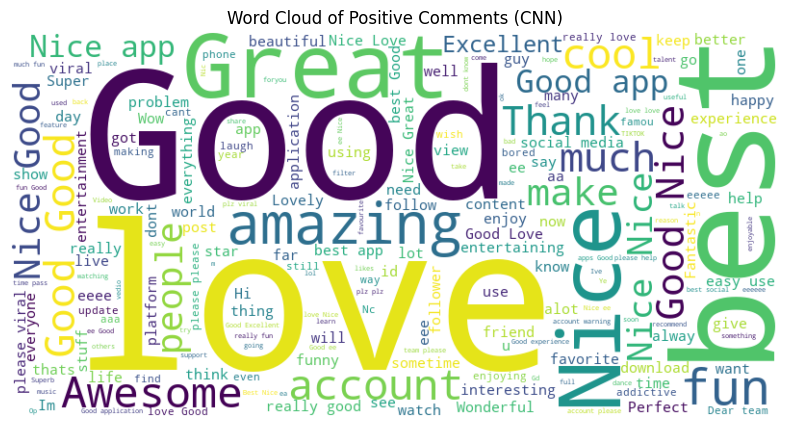

Top 50 words in negative comments (CNN): [('I', 40816), ('it', 24770), ('my', 24328), ('for', 12548), ('me', 12353), ('this', 12342), ('not', 11986), ('of', 11338), ('account', 11141), ('but', 10948), ('you', 10624), ('on', 10285), ('in', 8400), ('have', 8241), ('that', 7586), ('no', 7197), ('i', 6983), ('like', 6187), ('dont', 6058), ('cant', 6022), ('so', 5945), ('are', 5569), ('its', 5355), ('get', 4968), ('was', 4649), ('just', 4641), ('please', 4593), ('banned', 4552), ('It', 4454), ('Im', 4379), ('This', 4350), ('with', 4330), ('all', 4305), ('update', 4281), ('they', 4229), ('when', 4225), ('or', 4133), ('people', 4064), ('do', 4022), ('your', 4016), ('be', 3923), ('even', 3799), ('good', 3789), ('now', 3721), ('because', 3693), ('time', 3328), ('Its', 3161), ('My', 3144), ('very', 3131), ('bad', 3108)]


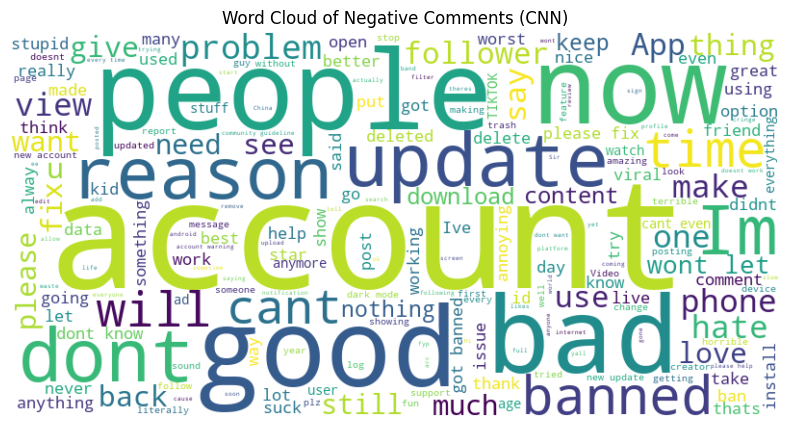

Top 50 words in neutral comments (CNN): [('I', 10494), ('it', 6916), ('but', 4959), ('my', 4890), ('good', 3840), ('for', 3221), ('you', 2902), ('Its', 2789), ('this', 2750), ('me', 2554), ('of', 2542), ('not', 2372), ('on', 2370), ('like', 2270), ('It', 2186), ('that', 2082), ('have', 2044), ('its', 1934), ('account', 1864), ('so', 1862), ('i', 1788), ('Ok', 1765), ('in', 1646), ('nice', 1444), ('dont', 1428), ('cant', 1416), ('This', 1321), ('very', 1310), ('just', 1246), ('when', 1198), ('get', 1187), ('are', 1173), ('no', 1148), ('love', 1117), ('please', 1104), ('be', 1080), ('Good', 1060), ('really', 1013), ('update', 1001), ('or', 981), ('can', 960), ('with', 958), ('people', 948), ('all', 938), ('was', 903), ('Im', 894), ('do', 886), ('great', 817), ('problem', 769), ('time', 764)]


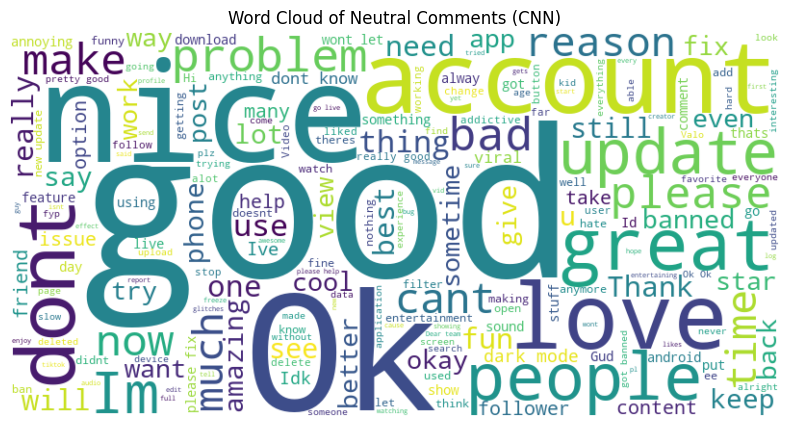

Top 50 words in positive comments (RNN): [('I', 264), ('so', 174), ('you', 150), ('it', 123), ('me', 87), ('my', 69), ('do', 66), ('in', 66), ('i', 63), ('get', 52), ('have', 49), ('for', 49), ('can', 47), ('love', 43), ('if', 42), ('of', 40), ('no', 40), ('be', 39), ('like', 35), ('good', 33), ('that', 32), ('but', 32), ('just', 32), ('go', 32), ('u', 31), ('he', 30), ('with', 30), ('was', 29), ('will', 27), ('not', 26), ('on', 26), ('much', 25), ('your', 24), ('b', 24), ('very', 24), ('dont', 23), ('all', 22), ('g', 22), ('we', 20), ('out', 19), ('are', 19), ('see', 19), ('h', 19), ('day', 19), ('back', 18), ('too', 18), ('its', 18), ('y', 18), ('by', 17), ('how', 17)]


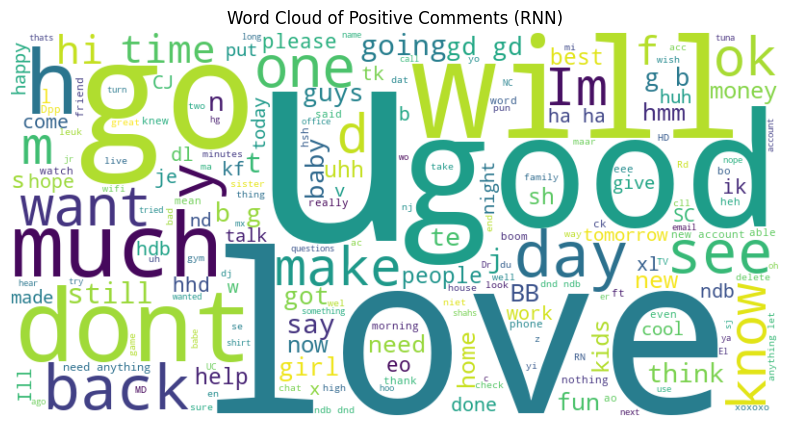

Top 50 words in negative comments (RNN): [('I', 177), ('very', 98), ('it', 88), ('you', 85), ('have', 54), ('do', 54), ('for', 41), ('my', 40), ('of', 39), ('not', 37), ('will', 37), ('me', 36), ('in', 35), ('so', 32), ('get', 32), ('be', 31), ('F', 30), ('can', 29), ('this', 26), ('as', 23), ('time', 23), ('but', 22), ('t', 22), ('if', 22), ('i', 22), ('your', 22), ('b', 21), ('h', 20), ('new', 20), ('was', 19), ('am', 19), ('no', 19), ('at', 19), ('with', 18), ('ho', 18), ('its', 17), ('G', 17), ('that', 16), ('he', 15), ('are', 15), ('see', 15), ('talk', 15), ('day', 15), ('just', 14), ('y', 14), ('we', 14), ('go', 14), ('name', 14), ('n', 13), ('u', 13)]


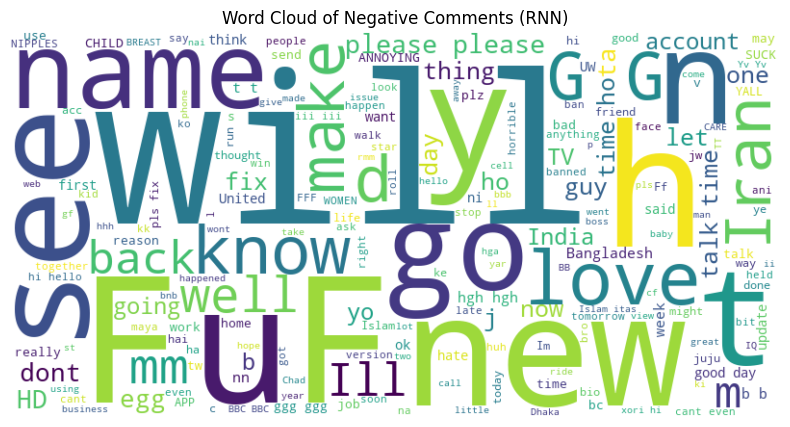

Top 50 words in neutral comments (RNN): [('I', 112858), ('it', 67331), ('my', 54370), ('this', 36546), ('good', 36138), ('Good', 36015), ('you', 34285), ('love', 32233), ('for', 31589), ('Nice', 30858), ('but', 28916), ('me', 26721), ('of', 25856), ('like', 24159), ('account', 22026), ('so', 21964), ('on', 21702), ('Its', 20794), ('not', 19482), ('have', 18268), ('very', 18147), ('i', 18092), ('in', 17438), ('that', 16218), ('its', 15964), ('This', 15932), ('Very', 15244), ('nice', 14822), ('please', 13822), ('best', 13203), ('It', 13075), ('Love', 12007), ('are', 11444), ('can', 11438), ('fun', 11170), ('with', 11149), ('no', 11105), ('all', 11041), ('Great', 10983), ('just', 10975), ('dont', 10914), ('get', 10814), ('people', 10293), ('be', 9637), ('Im', 9452), ('really', 9229), ('cant', 8949), ('your', 8859), ('time', 8785), ('viral', 8762)]


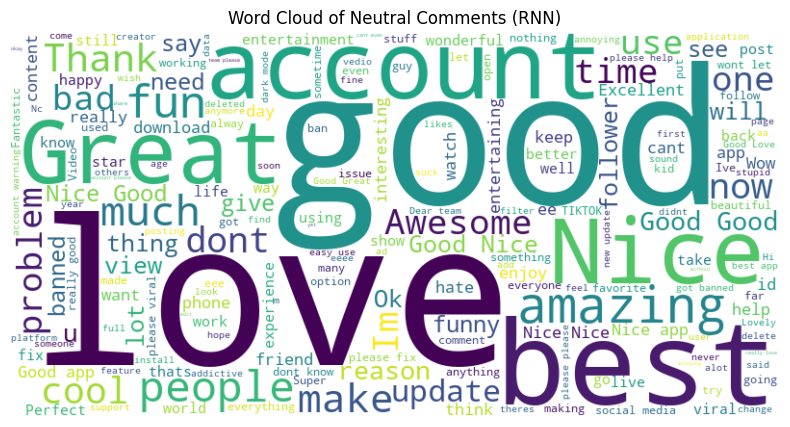

Top 50 words in positive comments (LSTM): [('I', 51142), ('Good', 34701), ('Nice', 30309), ('it', 29598), ('love', 29213), ('good', 27273), ('my', 18862), ('this', 18580), ('you', 16713), ('Its', 14047), ('very', 13803), ('Very', 13677), ('like', 13549), ('nice', 13342), ('for', 13053), ('so', 13044), ('best', 11927), ('Love', 11587), ('Great', 10477), ('fun', 9785), ('me', 9562), ('This', 9400), ('of', 9286), ('Best', 8534), ('i', 7279), ('It', 6765), ('apps', 6761), ('amazing', 6564), ('its', 6440), ('on', 6348), ('great', 6167), ('ee', 6136), ('can', 5973), ('please', 5817), ('viral', 5813), ('account', 5751), ('really', 5702), ('much', 5550), ('in', 5272), ('have', 5105), ('Amazing', 4956), ('all', 4762), ('with', 4458), ('ever', 4415), ('Awesome', 4357), ('The', 4352), ('So', 4225), ('App', 4190), ('just', 4112), ('people', 4093)]


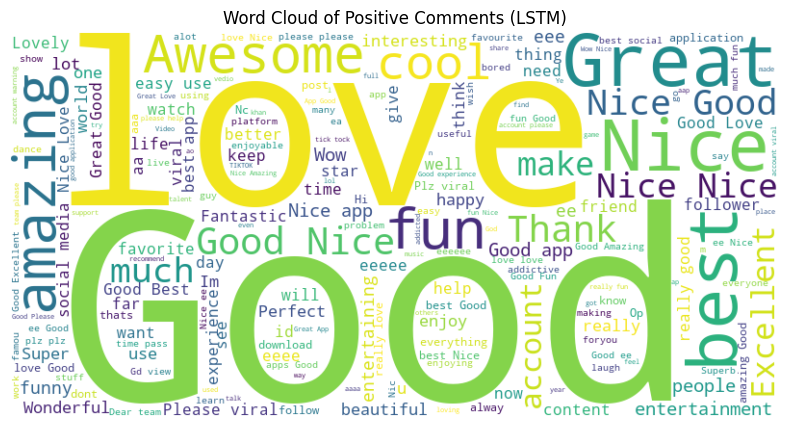

Top 50 words in negative comments (LSTM): [('I', 27066), ('it', 16002), ('my', 15331), ('this', 8644), ('me', 8345), ('of', 8310), ('for', 8253), ('not', 7840), ('account', 7185), ('on', 6899), ('you', 6462), ('in', 6020), ('no', 5349), ('have', 4920), ('but', 4777), ('that', 4634), ('cant', 4473), ('i', 4233), ('dont', 4163), ('banned', 3834), ('are', 3795), ('so', 3632), ('was', 3337), ('your', 3247), ('they', 3205), ('like', 3194), ('its', 3139), ('get', 3137), ('even', 3137), ('all', 3097), ('It', 3081), ('update', 3076), ('This', 3061), ('bad', 3051), ('Im', 3034), ('just', 2997), ('with', 2947), ('or', 2798), ('do', 2772), ('now', 2721), ('people', 2708), ('because', 2528), ('reason', 2510), ('be', 2449), ('when', 2254), ('let', 2250), ('time', 2220), ('got', 2212), ('will', 1991), ('out', 1942)]


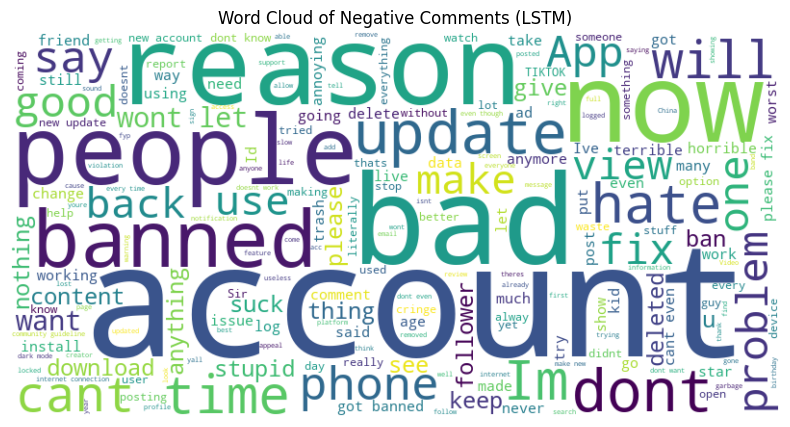

Top 50 words in neutral comments (LSTM): [('I', 35091), ('it', 21942), ('but', 20390), ('my', 20286), ('you', 11345), ('for', 10373), ('not', 10178), ('this', 9364), ('account', 9103), ('me', 8937), ('on', 8494), ('have', 8346), ('of', 8339), ('that', 7952), ('good', 7658), ('like', 7462), ('i', 6665), ('its', 6420), ('please', 6290), ('in', 6247), ('dont', 5578), ('so', 5494), ('Its', 5080), ('are', 4971), ('get', 4666), ('no', 4374), ('be', 4370), ('when', 4302), ('can', 4054), ('cant', 3954), ('just', 3912), ('with', 3792), ('problem', 3739), ('people', 3502), ('This', 3475), ('do', 3423), ('or', 3359), ('was', 3278), ('It', 3232), ('all', 3213), ('Im', 3035), ('if', 3020), ('very', 2986), ('some', 2889), ('love', 2820), ('update', 2786), ('time', 2773), ('they', 2750), ('My', 2694), ('really', 2663)]


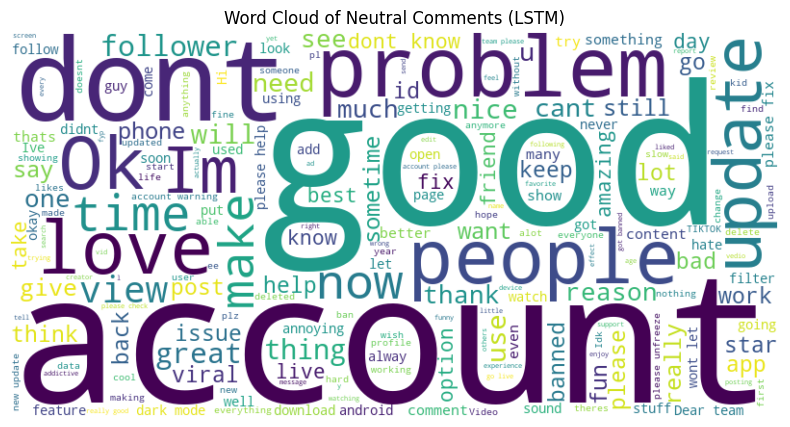

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
# def generate_wordclouds(X, y_pred, model_name):
#     categories = ['positive', 'negative', 'neutral']
#     for category in categories:
#         text = " ".join(X[y_pred == label_encoder.transform([category])[0]])
#         wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#         plt.figure(figsize=(10, 5))
#         plt.imshow(wordcloud, interpolation='bilinear')
#         plt.axis('off')
#         plt.title(f'Word Cloud of {category.capitalize()} Comments ({model_name})')
#         plt.show()
def generate_wordclouds(X, y_pred, model_name):
    categories = ['positive', 'negative', 'neutral']
    for category in categories:
        text = " ".join(X[y_pred == label_encoder.transform([category])[0]])
        word_freq = Counter(text.split())
        most_common_words = word_freq.most_common(50)
        print(f"Top 50 words in {category} comments ({model_name}): {most_common_words}")
        
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud of {category.capitalize()} Comments ({model_name})')
        plt.show()
generate_wordclouds(X, y_pred_all_cnn, 'CNN')
generate_wordclouds(X, y_pred_all_rnn, 'RNN')
generate_wordclouds(X, y_pred_all_lstm, 'LSTM')